In [1]:
!wget -O ratings.csv 'https://git.arts.ac.uk/raw/lmccallum/Personalisation/master/ml-latest-small/ratings.csv?token=AAAAAH5LZP4VFOOPDIIHUHLAWECVM' -q
!wget -O RecommenderMetrics.py 'https://git.arts.ac.uk/raw/lmccallum/Personalisation/master/code/RecommenderMetrics.py?token=AAAAAHZIG7BIMBFONPHELBTAWEDH6' -q
!wget -O movies.csv 'https://git.arts.ac.uk/raw/lmccallum/Personalisation/master/ml-latest-small/movies.csv?token=AAAAAHYJQVUNOY3KHVICURDAWEHAQ' -q
!pip install scikit-surprise -qq
!pip uninstall umap -qq #just in case
!pip install umap-learn[plot] -qq
!pip install umap-learn -qq 
#if does not work
#!pip install 'umap-learn==0.3.10'

     |████████████████████████████████| 11.8MB 8.7MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 1.2MB 22.3MB/s 
     |████████████████████████████████| 15.8MB 270kB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 706kB 34.6MB/s 
     |████████████████████████████████| 112kB 48.2MB/s 
ERROR: distributed 2021.5.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.5.0 has requirement dask==2021.05.0, but you'll have dask 2.12.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import KNNBaseline
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from RecommenderMetrics import RecommenderMetrics

In [3]:
df = pd.read_csv('/content/ratings.csv')
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()
#Manually making the dictionary
movie_id_to_index = {
    31: 1,
    1029: 2,
    1061: 3
}
#Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]
df["rating"].describe()
from sklearn.preprocessing import MinMaxScaler
##Pick the range
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))
from sklearn.model_selection import train_test_split
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs
y = df["rating"]
#Get train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
#Define the new class
class RecommenderNet(keras.Model):
    
    #Override init with new arguments 
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Make an embedding layer for users
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        #Make an embedding layer for user bias
        self.user_bias = layers.Embedding(num_users, 1)
        #Make an embedding layer for movies
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        #Make an embedding layer for movie bias
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        #inputs contains [[user,movie],[user,movie],[user,movie]...]
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        #Dot product 
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)
#Pick Embedding size
EMBEDDING_SIZE = 20
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=0.001)
)
#TRAIN
history = model.fit(x=x_train,y=y_train,batch_size=64, verbose=0, epochs=20,validation_data=(x_test, y_test))#Quiet, change verbose for more infos
#model.user_embedding.trainable_weights[0].numpy()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#Question 1: Find the mean diversity (1-similarity, based on movie embeddings) between each film in every users Top 10 films. 


In [4]:
mean_Diversity = 0.0 #this is a debugging trick I made: to prevent 0.0( or zero with more than 100s 
#zero after the comma) to be my mean diversity output, I define it 
#as an output already, prevent this from happening, leveraging a while loop.

while mean_Diversity == 0.0:

  movie_data = pd.read_csv("/content/movies.csv")
  #creating a list (detailed score for each top 10 users (as a list))
  score_list = []
  user = 0
  while len(score_list) < 10:
    n = 10
    x = [[user, i] for i in np.arange(num_movies)]
    predicted_ratings = model.predict(x).flatten()
    top_n_indexes = predicted_ratings.argsort()[-n:]
    top_n = [movie_data[movie_data["movieId"]==movie_ids[i]]["title"] for i in top_n_indexes]
    #Convert top_n from list to datframe
    df = pd.DataFrame(top_n)
    #Transposing index and columns from the dataframe
    df1_transposed = df.T 
    #Merging columns, reducing the dataframe size
    #https://stackoverflow.com/questions/24390645/python-pandas-merge-samed-name-columns-in-a-dataframe
    def sjoin(x): return ';'.join(x[x.notnull()].astype(str))
    df1_transposed=df1_transposed.groupby(level=0, axis=1).apply(lambda x: x.apply(sjoin, axis=1))
    #append detailed score to b_list for each top 10 user
    score_list.append(df1_transposed) 
    #Save everything into a .csv (dumping it as a .csv seem to be faster than storing it into a dataframe)
    df1_transposed.to_csv('my_csv.csv', mode='a', header=True)
    user  += 1
    rat = pd.read_csv('/content/my_csv.csv', header=None)
    rat.columns = ["movieId","Title"]
    rat=rat.dropna()
    rat_copy=rat.copy()
    ratings_data = pd.read_csv("/content/ratings.csv")
    result = pd.merge( rat_copy, ratings_data, on=["movieId"])

    mean_Diversity=1-cosine_similarity(result['rating'].values.reshape(1, -1)).mean()
    
  
print('mean diversity =','%.100f' % mean_Diversity) 
print('or in scientific notation ', mean_Diversity)

mean diversity = 0.0000000000000003330669073875469621270895004272460937500000000000000000000000000000000000000000000000
or in scientific notation  3.3306690738754696e-16


#Question 2: Mean popularity (e.g. mean rating) of the films in every users Top 10 films 

In [6]:
# Mean of all the dataset's popularity values
result['rating'].mean()

3.269741985926505

In [7]:
#Mean value for popularity top 10 users
ratmean=result.groupby('Title').mean()
#Sort by higher mean popularity value
ratmean=ratmean.sort_values(by='rating',ascending=False)
# Fix table style
mean_Popularity=ratmean.reset_index()
#Each movie mean popularity top 10 users
mean_Popularity=mean_Popularity.rename(columns={"rating": "mean_Popularity"})
mean_Popularity=mean_Popularity[['Title', 'mean_Popularity']]
mean_Popularity.head()

,Title,mean_Popularity
0,Ran (1985),4.285714
1,"Princess Bride, The (1987)",4.225806
2,Modern Times (1936),4.166667
3,"Godfather, The (1972)",4.000000
4,Roger & Me (1989),4.000000


#Question 3: Using a dimensionality reduction approach, plot the top 30 best rated films on a 2-D graph based on their movie embeddings

In [8]:
#Dimension reduction of 30 best ranked movies.


predicted_ratings = model.predict(x).flatten()
top_n_indexes = predicted_ratings.argsort()
top_n = [movie_data[movie_data["movieId"]==movie_ids[i]]["title"] for i in top_n_indexes]
df = pd.DataFrame(top_n)
df1_transposed = df.T 
def sjoin(x): return ';'.join(x[x.notnull()].astype(str))
df1_transposed=df1_transposed.groupby(level=0, axis=1).apply(lambda x: x.apply(sjoin, axis=1))
df1_transposed.to_csv('my_csv2.csv', mode='a', header=True)
koo = pd.read_csv('/content/my_csv2.csv', header=None)
koo.columns = ["movieId","Title"]
df1_transposed=koo.dropna()
result = pd.merge( df1_transposed, ratings_data, on=["movieId"])




In [9]:
ratmean=result.groupby('Title').mean().sort_values(by='rating',ascending=False)
mean_Popularity=ratmean.reset_index()
mean_Popularity=mean_Popularity.rename(columns={"rating": "mean_Popularity"})
mean_Popularity=mean_Popularity[['Title', 'mean_Popularity']]
mean_Popularity

,Title,mean_Popularity
0,"Experts, The (1989)",5.0
1,Shaft (1971),5.0
2,Diabolique (1996),5.0
3,Sightseers (2012),5.0
4,Weird Science (1985),5.0
...,...,...
5611,"Santa Clause 3: The Escape Clause, The (2006)",0.5
5612,"Ugly Truth, The (2009)",0.5
5613,"36th Chamber of Shaolin, The (Shao Lin san shi...",0.5
5614,Frailty (2001),0.5


In [10]:
import umap.umap_ as umap
import umap.plot
%matplotlib inline
#Sort top 30 values, dropping names if they are mentioned more than once.
rat_copy=mean_Popularity.iloc[:30]
#Reshaping and fitting into umap
embedding = umap.UMAP().fit(rat_copy['mean_Popularity'].values.reshape(-1, 1))


/usr/local/lib/python3.7/dist-packages/umap/plot.py:855: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


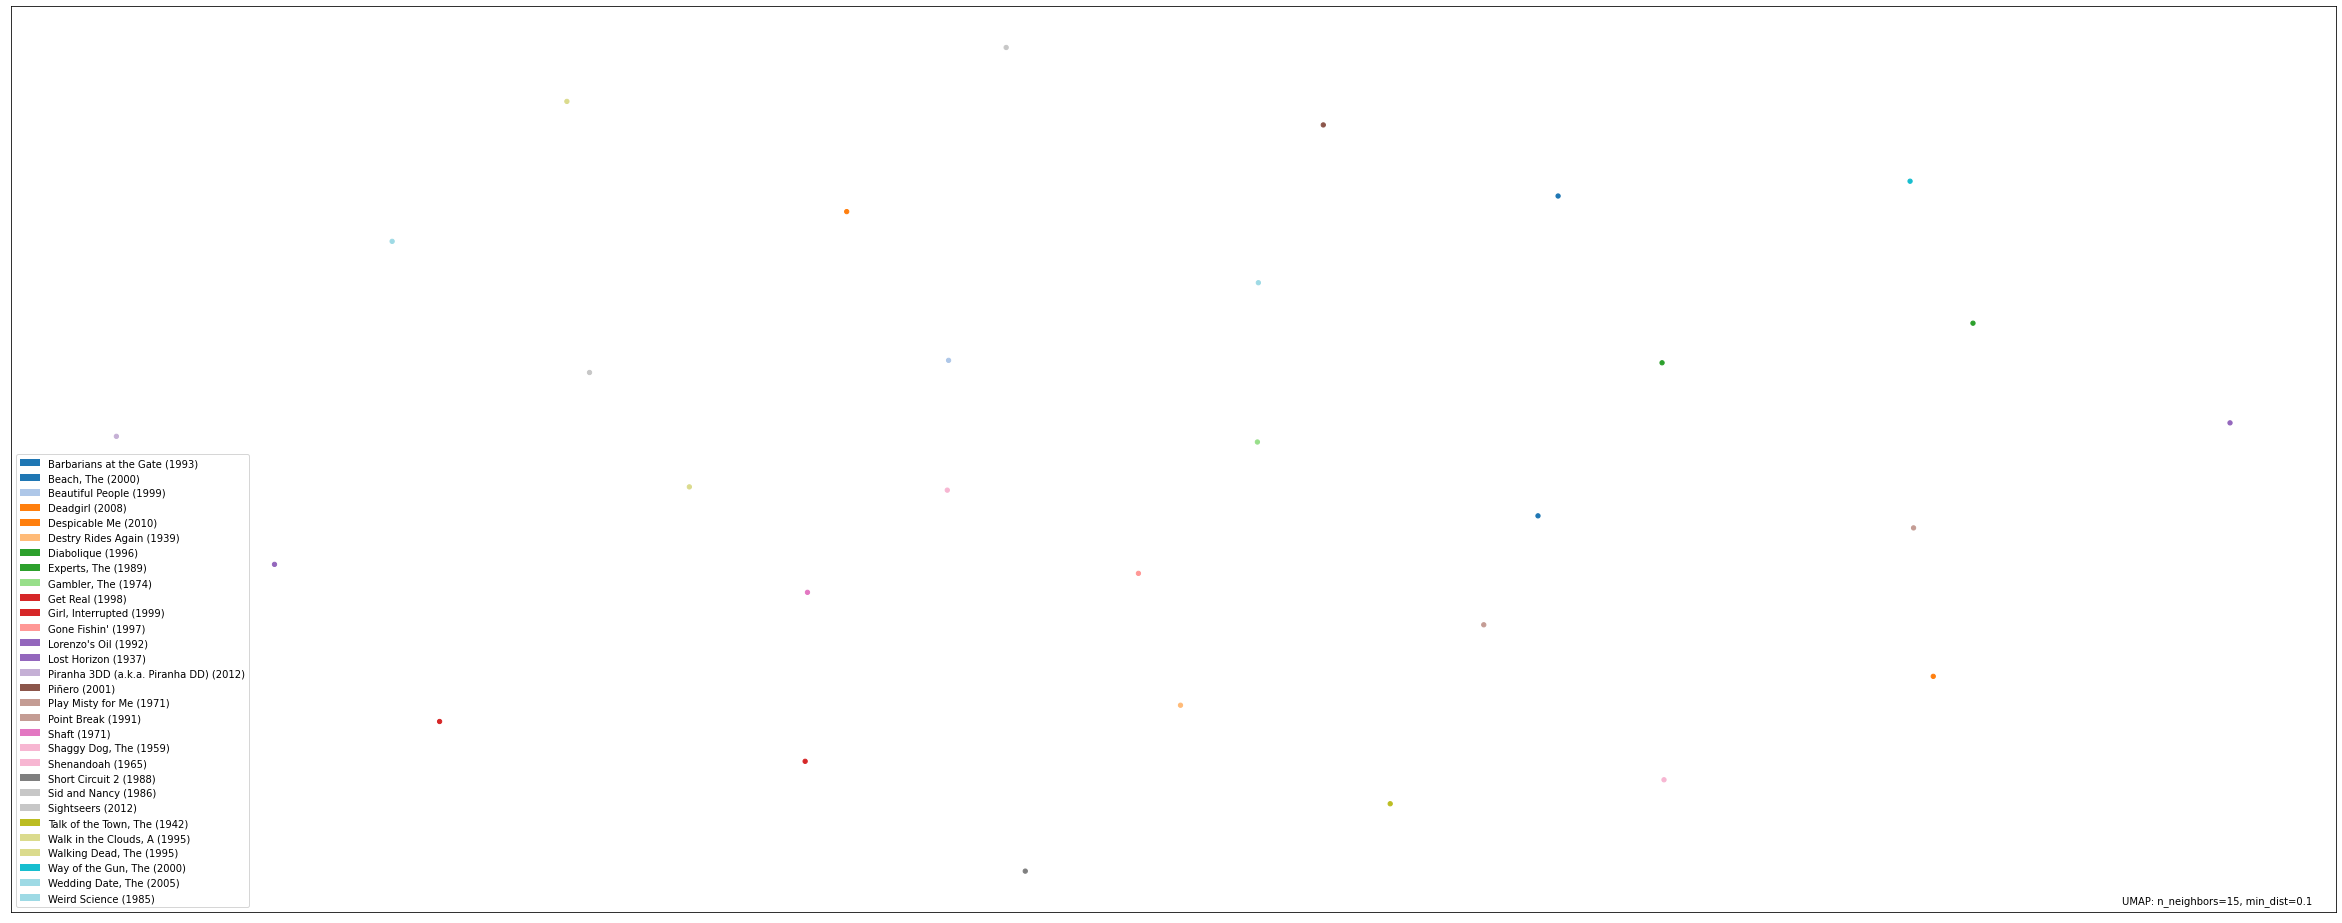

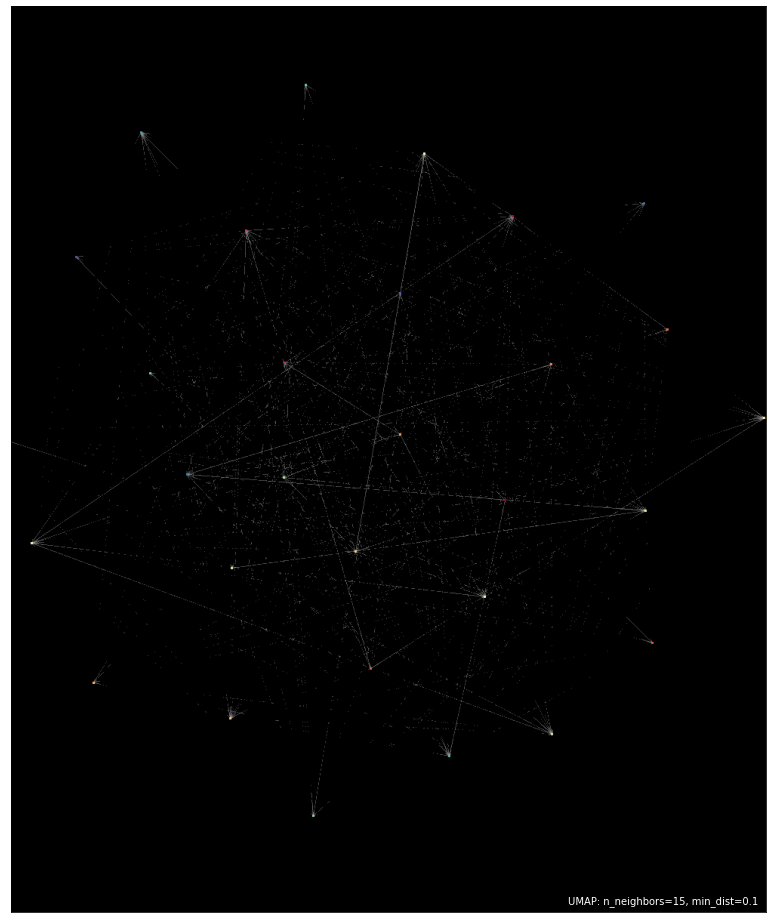

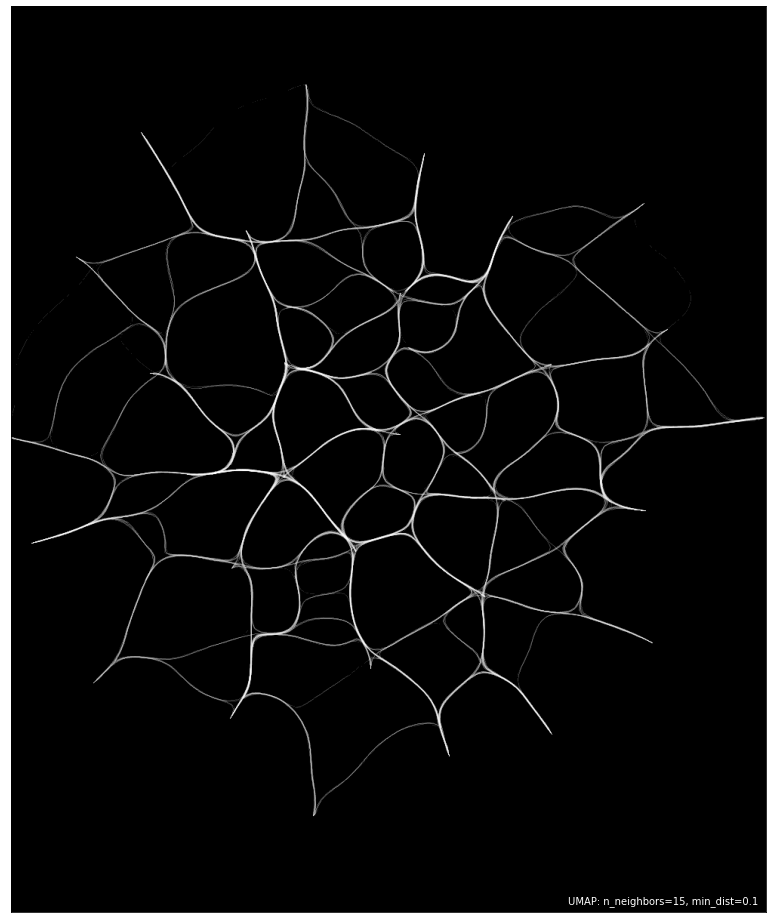

In [11]:
#Plotting using umap module
#Points with labels
umap.plot.points(embedding,labels = rat_copy['Title'], theme='blue', width=3000, height=1200)
#Connectivity (labels not really supported by .connectivity option, they just get colors rather than be monohromatic)
umap.plot.connectivity(embedding, show_points=True,labels = rat_copy['Title'], theme='inferno', width=1000, height=1200)
umap.plot.connectivity(embedding, edge_bundling='hammer', theme='inferno', width=1000, height=1200)